In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd My Drive

/content/drive/My Drive


In [ ]:
%ls pyghack_data/

champaign_data.py         land_area.csv            us-counties_covid19.csv
Champaign_zipcode.gsheet  mask-use-by-county.csv   us-counties_coviddeaths.csv
Education.csv             PopulationEstimates.csv  us_pop_data.csv
il.1990_2018.19ages.txt   PovertyEstimates.csv
illinois_population.csv   Unemployment.csv


In [ ]:
df_unem = pd.read_csv('pyghack_data/Unemployment.csv')
df_unem = df_unem[['FIPStxt','Unemployment_rate_2019','Median_Household_Income_2018']]

In [ ]:
df_poverty = pd.read_csv('/content/drive/My Drive/pyghack_data/PovertyEstimates.csv')
df_poverty = df_poverty[['FIPStxt','PCTPOVALL_2018']]

In [ ]:
df_edu = pd.read_csv('/content/drive/My Drive/pyghack_data/Education.csv')

In [ ]:
df_edu.rename(columns = {'FIPS Code':'FIPStxt'}, inplace = True)

In [ ]:
df_land = pd.read_csv('/content/drive/My Drive/pyghack_data/land_area.csv')

In [ ]:
df_tpop = pd.read_csv('/content/drive/My Drive/pyghack_data/PopulationEstimates.csv')

In [ ]:
df_features1 = df_unem
df_features1 = pd.merge(df_features1,df_poverty,how='inner', on ='FIPStxt')
df_features1 = pd.merge(df_features1,df_edu,how='inner', on ='FIPStxt')
df_features1 = pd.merge(df_features1,df_land,how='inner', on ='FIPStxt')
df_features1 = pd.merge(df_features1,df_tpop,how='inner', on ='FIPStxt')
df_features1.pop('Unnamed: 2')
df_features1.rename(columns = {'FIPStxt':'fips','Unemployment_rate_2019':'Unemployment_rate','Median_Household_Income_2018':'Median_Household_Income','PCTPOVALL_2018':'poverty_rate','POP_ESTIMATE_2019':'total_pop'}, inplace = True)
df_features1['Median_Household_Income']=df_features1['Median_Household_Income'].apply(lambda x: ''.join(c for c in x if c.isnumeric()))
df_features1['total_pop']=df_features1['total_pop'].apply(lambda x: ''.join(c for c in x if c.isnumeric()))
df_features1 = df_features1.astype({'fips':int, 'Unemployment_rate':float, 'Median_Household_Income':float,
       'poverty_rate':float, 'no_edu':float, 'high_school':float, 'college_drop':float, 'college':float, 'land_area':float, 'total_pop':float})
df_features1['pop_density'] = df_features1['total_pop']/df_features1['land_area']

In [ ]:
df_features1

,fips,Unemployment_rate,Median_Household_Income,poverty_rate,no_edu,high_school,college_drop,college,land_area,total_pop,pop_density
0,0,3.7,61937.0,13.1,12.3,27.1,29.0,31.5,3531905.43,328239523.0,92.935536
1,1000,3.0,49881.0,16.8,14.2,30.9,29.9,24.9,50645.33,4903185.0,96.814158
2,1001,2.7,59338.0,13.8,11.3,32.6,28.4,27.7,594.44,55869.0,93.985936
3,1003,2.7,57588.0,9.8,9.7,27.6,31.3,31.3,1589.78,223234.0,140.418171
4,1005,3.8,34382.0,30.9,27.0,35.7,25.1,12.2,884.88,24686.0,27.897568
...,...,...,...,...,...,...,...,...,...,...,...
3186,56037,3.9,73315.0,8.4,9.0,33.3,35.7,22.0,10426.65,42343.0,4.061036
3187,56039,2.7,99087.0,6.3,5.6,13.2,23.8,57.4,3995.38,23464.0,5.872783
3188,56041,3.9,63401.0,10.0,7.2,40.1,37.2,15.4,2081.26,20226.0,9.718152
3189,56043,3.9,55190.0,11.9,10.4,30.3,37.7,21.5,2238.55,7805.0,3.486632


In [ ]:
maskdf = pd.read_csv('/content/drive/My Drive/pyghack_data/mask-use-by-county.csv')
maskdf = maskdf.rename(columns={"COUNTYFP": "fips"})
maskdf['fips'] = maskdf['fips'].astype(int)
cdeath_df = pd.read_csv('/content/drive/My Drive/pyghack_data/us-counties_coviddeaths.csv')
coviddf = cdeath_df.merge(maskdf, on=['fips'],how='inner')
coviddf['fips'] = coviddf['fips'].astype(int)
coviddf = coviddf.drop(columns=['date'])
coviddf.pop('county')
coviddf.pop('state')
coviddf['no_mask']=coviddf['NEVER']+coviddf['RARELY']

In [ ]:
df_features2 = pd.merge(df_features1,coviddf,how='inner', on ='fips')

In [ ]:
df_features2['death_rate'] = df_features2['deaths']/df_features2['total_pop']

In [ ]:
df_features2

,fips,Unemployment_rate,Median_Household_Income,poverty_rate,no_edu,high_school,college_drop,college,land_area,total_pop,pop_density,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,no_mask,death_rate
0,1001,2.7,59338.0,13.8,11.3,32.6,28.4,27.7,594.44,55869.0,93.985936,1738,25.0,1565.0,24.0,173.0,1.0,0.053,0.074,0.134,0.295,0.444,0.127,0.000447
1,1003,2.7,57588.0,9.8,9.7,27.6,31.3,31.3,1589.78,223234.0,140.418171,5165,50.0,4979.0,46.0,186.0,4.0,0.083,0.059,0.098,0.323,0.436,0.142,0.000224
2,1005,3.8,34382.0,30.9,27.0,35.7,25.1,12.2,884.88,24686.0,27.897568,857,7.0,657.0,7.0,200.0,0.0,0.067,0.121,0.120,0.201,0.491,0.188,0.000284
3,1007,3.1,46064.0,21.8,16.8,47.3,24.4,11.5,622.58,22394.0,35.969675,642,10.0,611.0,6.0,31.0,4.0,0.020,0.034,0.096,0.278,0.572,0.054,0.000447
4,1009,2.7,50412.0,13.2,19.8,34.0,33.5,12.6,644.78,57826.0,89.683303,1594,15.0,1236.0,15.0,358.0,0.0,0.053,0.114,0.180,0.194,0.459,0.167,0.000259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,56037,3.9,73315.0,8.4,9.0,33.3,35.7,22.0,10426.65,42343.0,4.061036,328,2.0,310.0,NaN,18.0,NaN,0.061,0.295,0.230,0.146,0.268,0.356,0.000047
3120,56039,2.7,99087.0,6.3,5.6,13.2,23.8,57.4,3995.38,23464.0,5.872783,529,1.0,496.0,NaN,33.0,NaN,0.095,0.157,0.160,0.247,0.340,0.252,0.000043
3121,56041,3.9,63401.0,10.0,7.2,40.1,37.2,15.4,2081.26,20226.0,9.718152,347,2.0,283.0,NaN,64.0,NaN,0.098,0.278,0.154,0.207,0.264,0.376,0.000099
3122,56043,3.9,55190.0,11.9,10.4,30.3,37.7,21.5,2238.55,7805.0,3.486632,112,6.0,103.0,NaN,9.0,NaN,0.204,0.155,0.069,0.285,0.287,0.359,0.000769


In [ ]:
df_hr_uspop = pd.read_csv('/content/drive/My Drive/pyghack_data/us_pop_data.csv')
df_hr_uspop.pop('non-hispanic')
df_hr_uspop.pop('population')
df_hr_uspop.rename(columns = {'county':'fips','asian / pacific islander':'asian','amerian indian/alaska native':'native','PCTPOVALL_2018':'poverty_rate','POP_ESTIMATE_2019':'total_pop'}, inplace = True)
df_hr_uspop.keys()
df_feat = pd.merge(df_features2,df_hr_uspop,how='inner', on ='fips')

In [ ]:
df_feat.keys()

Index(['fips', 'Unemployment_rate', 'Median_Household_Income', 'poverty_rate',
       'no_edu', 'high_school', 'college_drop', 'college', 'land_area',
       'total_pop', 'pop_density', 'cases', 'deaths', 'confirmed_cases',
       'confirmed_deaths', 'probable_cases', 'probable_deaths', 'NEVER',
       'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'no_mask', 'death_rate',
       'black', 'white', 'asian', 'native', 'hispanic', '0', '0-4', '12-16',
       '16-20', '20-24', '24-28', '28-32', '32-36', '36-40', '4-8', '40-44',
       '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', '68-72', '8-12',
       'Female', 'Male'],
      dtype='object')

In [ ]:
df_train=df_feat[['Unemployment_rate', 'Median_Household_Income', 'poverty_rate',
       'no_edu', 'high_school', 'college_drop', 'college', 'land_area',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic', '0', '0-4', '12-16',
       '16-20', '20-24', '24-28', '28-32', '32-36', '36-40', '4-8', '40-44',
       '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', '68-72', '8-12',
       'Female', 'Male']]

In [ ]:
train_dataset = df_feat.sample(frac=0.8,random_state=0)
test_dataset = df_feat.drop(train_dataset.index)

train_label = train_dataset['deaths']
test_label = test_dataset['deaths']

train_nmlabel = train_dataset['no_mask']
test_nmlabel = test_dataset['no_mask']


train_dataset = train_dataset[['Unemployment_rate', 'Median_Household_Income', 'poverty_rate',
       'no_edu', 'high_school', 'college_drop', 'college', 'land_area',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic', '0', '0-4', '12-16',
       '16-20', '20-24', '24-28', '28-32', '32-36', '36-40', '4-8', '40-44',
       '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', '68-72', '8-12',
       'Female', 'Male']]
test_dataset = test_dataset[['Unemployment_rate', 'Median_Household_Income', 'poverty_rate',
       'no_edu', 'high_school', 'college_drop', 'college', 'land_area',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic', '0', '0-4', '12-16',
       '16-20', '20-24', '24-28', '28-32', '32-36', '36-40', '4-8', '40-44',
       '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', '68-72', '8-12',
       'Female', 'Male']]

df_trim = df_feat[['Unemployment_rate', 'Median_Household_Income', 'poverty_rate',
       'no_edu', 'high_school', 'college_drop', 'college', 'land_area',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic', '0', '0-4', '12-16',
       '16-20', '20-24', '24-28', '28-32', '32-36', '36-40', '4-8', '40-44',
       '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', '68-72', '8-12',
       'Female', 'Male']]

In [ ]:
train_stats = df_trim.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Unemployment_rate,3123.0,3.991451,1.446786,1.400000,3.000000,3.700000,4.600000,1.830000e+01
Median_Household_Income,3123.0,52777.873199,13864.607924,25385.000000,43684.500000,50565.000000,58786.000000,1.403820e+05
poverty_rate,3123.0,15.148095,6.080323,2.600000,10.800000,14.100000,18.300000,4.840000e+01
no_edu,3123.0,13.406980,6.333681,1.200000,8.800000,12.100000,17.200000,6.630000e+01
high_school,3123.0,34.305059,7.175804,5.500000,29.900000,34.600000,39.300000,5.560000e+01
college_drop,3123.0,30.725648,5.161211,5.800000,27.300000,30.600000,34.200000,4.800000e+01
college,3123.0,21.561191,9.408110,5.400000,15.000000,19.200000,25.600000,7.850000e+01
land_area,3123.0,1116.258469,3607.226347,2.000000,431.125000,615.200000,923.245000,1.455048e+05
total_pop,3123.0,102399.200128,327215.415098,404.000000,11019.500000,25844.000000,67920.000000,1.003911e+07
pop_density,3123.0,219.841673,814.460963,0.035944,16.874346,45.037338,118.572592,1.880838e+04


In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
train_dataset = norm(train_dataset)
test_dataset = norm(test_dataset)
train_stats2 = train_dataset.describe()
train_stats2 = train_stats2.transpose()
train_stats2

,count,mean,std,min,25%,50%,75%,max
Unemployment_rate,2498.0,0.000569,0.998854,-1.652940,-0.685278,-0.201447,0.420622,9.889884
Median_Household_Income,2498.0,-0.000387,1.028870,-1.975741,-0.664128,-0.166530,0.417691,6.318543
poverty_rate,2498.0,0.009788,1.015464,-2.063722,-0.715109,-0.155928,0.534824,5.024717
no_edu,2498.0,0.003897,0.999559,-1.927312,-0.727378,-0.206354,0.598865,8.351071
high_school,2498.0,0.007133,1.002630,-4.014193,-0.627812,0.055038,0.720468,2.967603
college_drop,2498.0,-0.002604,1.008331,-4.829418,-0.683105,-0.024345,0.692541,3.346957
college,2498.0,-0.006662,1.002697,-1.717794,-0.708027,-0.261603,0.437262,6.052099
land_area,2498.0,-0.009335,0.731634,-0.308896,-0.190309,-0.139625,-0.052644,24.278807
total_pop,2498.0,-0.005474,0.951315,-0.311707,-0.279509,-0.232826,-0.107648,30.367481
pop_density,2498.0,0.009839,1.070318,-0.269840,-0.249162,-0.215189,-0.125052,22.823124


In [ ]:
def build_model_DNN(input_len):
  model = keras.Sequential([
    # layers.Conv1D(filters=16, kernel_size=3,activation='relu',input_shape=[8,1]),
    # layers.Conv1D(filters=16, kernel_size=3,activation='relu'),
    # layers.Conv1D(filters=16, kernel_size=3,activation='relu'),
    # layers.MaxPooling1D(),
    # layers.Flatten(),
    layers.Dense(128, activation='relu',input_shape=[input_len]),
    # layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='msle',
                optimizer='adam',
                metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])
  return model

In [ ]:
print(len(train_dataset.keys()))
model = build_model_DNN(len(train_dataset.keys()))

36


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               4736      
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 100
# train_array = np.array(train_dataset.to_numpy())
history = model.fit(
  train_dataset, train_label,batch_size=16,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
125/125 [==============================] - 0s 4ms/step - loss: 3.3498 - mae: 51.6200 - mse: 54587.1641 - msle: 3.3498 - mape: 381812384.0000 - kullback_leibler_divergence: 0.0900 - val_loss: 2.3694 - val_mae: 58.3740 - val_mse: 63801.0508 - val_msle: 2.3694 - val_mape: 654655872.0000 - val_kullback_leibler_divergence: 0.0082
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 1.8489 - mae: 48.9698 - mse: 52665.4727 - msle: 1.8489 - mape: 608771200.0000 - kullback_leibler_divergence: 0.1481 - val_loss: 1.8642 - val_mae: 56.0894 - val_mse: 61985.6680 - val_msle: 1.8642 - val_mape: 739522496.0000 - val_kullback_leibler_divergence: 0.0185
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 1.5694 - mae: 47.4084 - mse: 51292.1719 - msle: 1.5694 - mape: 642813440.0000 - kullback_leibler_divergence: 0.0893 - val_loss: 1.6297 - val_mae: 54.6390 - val_mse: 60618.0586 - val_msle: 1.6297 - val_mape: 612278080.0000 - val_kullback_leibler_di

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
95,0.258010,25.764427,13675.345703,0.258010,264031904.0,0.345095,0.838719,36.583588,23895.767578,0.838719,457845824.0,1.179651,95
96,0.264065,25.844822,13814.180664,0.264065,254127872.0,0.300266,0.833615,36.463848,24187.425781,0.833615,444608096.0,0.868341,96
97,0.251301,25.647350,13613.465820,0.251301,250535200.0,0.284534,0.810318,36.435734,23996.800781,0.810318,418781984.0,0.797122,97
98,0.242702,25.683840,13605.430664,0.242702,253036656.0,0.278608,0.847278,36.594650,23875.574219,0.847278,462255616.0,0.827245,98
99,0.251011,25.604721,13573.673828,0.251011,258793072.0,0.266200,0.795978,36.521061,23773.062500,0.795978,396955040.0,1.024647,99


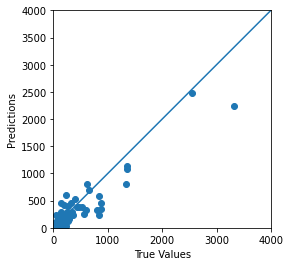

In [ ]:
test_predictions = model.predict(test_dataset,batch_size=512).flatten()
test_pred=(test_predictions).flatten()
test_lab=(test_label).to_numpy().flatten()
test_pred[test_pred<0]=0
a = plt.axes(aspect='equal')
plt.scatter(test_lab, test_pred,)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 4000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Text(0, 0.5, 'ML output')

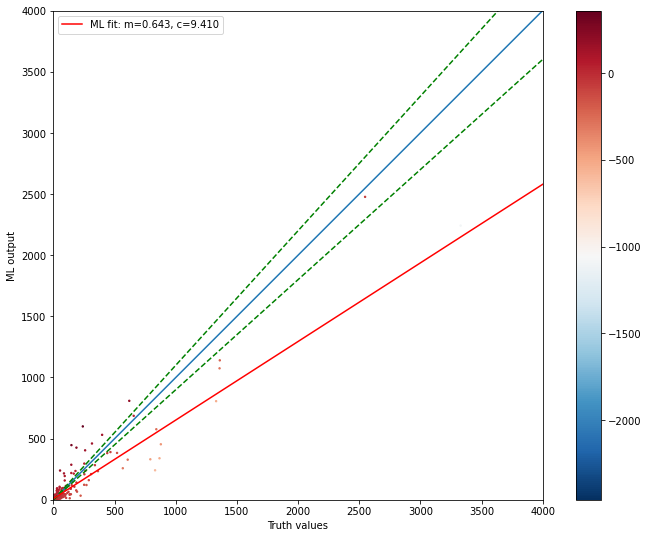

In [ ]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(12, 9))
def line(x,m,c):
    return (m*x)+c
popt, pcov = curve_fit(line, test_lab, test_pred)
x_points = np.linspace(0, 4000, 100)
error = (test_pred - test_lab)
a = plt.axes(aspect='equal')
plt.scatter(test_lab, test_pred,c=error,cmap='RdBu_r',s=2 )
plt.colorbar()
lims = [0, 4000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
_ = plt.plot(lims, [0,4400],'g--')
_ = plt.plot(lims, [0,3600],'g--')
_ =plt.plot(x_points, line(x_points, *popt), 'r-', label='ML fit: m=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.xlabel('Truth values')
plt.ylabel('ML output')

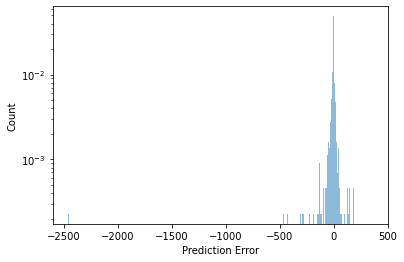

In [ ]:
error = (test_pred - test_lab)
plt.hist(error, bins = 400, alpha=0.5,density=True)
plt.xlabel("Prediction Error")
plt.yscale('log')
_ = plt.ylabel("Count")